
# ConvNeXtBase기반 모델 실험 (Colab)


In [3]:
import matplotlib.pyplot as plt
from matplotlib.image import imread
import tensorflow as tf
import keras
from tensorflow.keras import layers, models
from tensorflow import keras
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import ConvNeXtBase # 이 부분을 원하는 모델로 바꾸기
import splitfolders
import pandas as pd
from tensorflow.python.client import device_lib
import os

In [2]:
!pip install split-folders

In [4]:
# 구글 코랩 드라이브와 마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#gpu 구동. 이후에 키면 모든걸 다 gpu를 사용하니 참고할 것. 끄려면 0 >> -1로 바꾸자
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [5]:
# data_dir = '/content/drive/MyDrive/3_1_data/dataset' << 코랩 사용시 해당 경로를 참고하자

# 입력 폴더 경로
input_folder = '/content/drive/MyDrive/dataset'  # 이미지 데이터가 있는 폴더 경로
#단체코랩 실행 시 혹은 로컬에서 진행 시 개인 사정에 맞출 것

# 출력 폴더 경로 설정 및 분할 비율 설정
output_folder = '/content/drive/MyDrive/dataset_output'  # 분할된 데이터가 저장될 폴더 경로
#단체코랩 실행 시 혹은 로컬에서 진행 시 개인 사정에 맞출 것

splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(0.6, 0.2, 0.2))

Copying files: 3248 files [24:06,  2.25 files/s]


In [6]:
data_dir = '/content/drive/MyDrive/dataset_output'# train, val, test가 저장된 아웃풋 데이터 경로
train_dir = data_dir + '/train'
val_dir = data_dir + '/val'
test_dir = data_dir + '/test'

In [7]:
img_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, #수평 augmentation, 정규화
    featurewise_std_normalization=True,
    samplewise_std_normalization=True,
    horizontal_flip=True,
    validation_split=0.2)

/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1460: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, which overrides setting of `featurewise_center`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1469: UserWarning: This ImageDataGenerator specifies `samplewise_std_normalization`, which overrides setting of `samplewise_center`.
  warnings.warn(


In [8]:
train_ds = img_gen.flow_from_directory(directory=train_dir,
                                       target_size=(224, 224),
                                       class_mode='binary',
                                       color_mode='rgb',
                                       subset='training',
                                       batch_size=64)

Found 1559 images belonging to 2 classes.


In [9]:
val_ds = img_gen.flow_from_directory(directory=val_dir,
                                     target_size=(224,224),
                                     class_mode='binary',
                                     color_mode='rgb',
                                     subset='training',
                                     batch_size=64)

Found 519 images belonging to 2 classes.


In [10]:
test_ds = img_gen.flow_from_directory(directory=test_dir,
                                     target_size=(224,224),
                                     class_mode='binary',
                                     color_mode='rgb',
                                     subset='training',
                                     batch_size=64)

Found 522 images belonging to 2 classes.


In [17]:
# 미리 학습된 모델을 불러오기 >> 이름 전부 다 바꿔야 함
preprocess_input = tf.keras.applications.convnext.preprocess_input
#텐서플로우 홈페이지를 참고해 해당 모델의 preprocess_input을 파악할 것
#https://www.tensorflow.org/api_docs/python/tf/keras/applications/convnext/preprocess_input#args

ConBase_model = ConvNeXtBase(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

ConBase_model.trainable = False #모델model freeszing (Dense만 사용하게끔!)

In [18]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer1 = layers.Dense(128, activation='relu')
prediction_layer2 = layers.Dense(1, activation='sigmoid')

In [19]:
inputs = tf.keras.Input(shape=(224,224,3))
x = preprocess_input(inputs)
x = ConBase_model(x, training=False) # 위에서 설정한 모델명 변수명을 넣을 것
x = global_average_layer(x)
# outputs = prediction_layer1(x)
outputs = prediction_layer2(x)
model = tf.keras.Model(inputs, outputs)

In [20]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 convnext_base (Functional)  (None, 7, 7, 1024)        87566464  
                                                                 
 global_average_pooling2d_1  (None, 1024)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_3 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 87567489 (334.04 MB)
Trainable params: 1025 (4.00 KB)
Non-trainable params: 87566464 (334.04 MB)
_________________________________________________________________


In [21]:
lr = 0.0001

# 손실 함수 설정
loss_function = tf.keras.losses.BinaryCrossentropy(from_logits=True)
# 옵티마이저 설정
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
# 모델 컴파일
model.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy'])
# 모델 요약 확인
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 convnext_base (Functional)  (None, 7, 7, 1024)        87566464  
                                                                 
 global_average_pooling2d_1  (None, 1024)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_3 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 87567489 (334.04 MB)
Trainable params: 1025 (4.00 KB)
Non-trainable params: 87566464 (334.04 MB)
_________________________________________________________________


In [ ]:
from tensorflow.python.client import device_lib
import os

In [ ]:
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2070353870054471454
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14626652160
locality {
  bus_id: 1
  links {
  }
}
incarnation: 18027583315537527327
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [22]:
history = model.fit(train_ds, epochs=20,
                    validation_data=val_ds)

/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1862: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1872: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


25/25 [==============================] - 106s 3s/step - loss: 0.6982 - accuracy: 0.5202 - val_loss: 0.6774 - val_accuracy: 0.5780
Epoch 2/20
25/25 [==============================] - 64s 3s/step - loss: 0.6668 - accuracy: 0.5965 - val_loss: 0.6533 - val_accuracy: 0.6166
Epoch 3/20
25/25 [==============================] - 64s 3s/step - loss: 0.6422 - accuracy: 0.6549 - val_loss: 0.6310 - val_accuracy: 0.6590
Epoch 4/20
25/25 [==============================] - 69s 3s/step - loss: 0.6210 - accuracy: 0.6998 - val_loss: 0.6102 - val_accuracy: 0.6724
Epoch 5/20
25/25 [==============================] - 68s 3s/step - loss: 0.6027 - accuracy: 0.7242 - val_loss: 0.5944 - val_accuracy: 0.7129
Epoch 6/20
25/25 [==============================] - 62s 2s/step - loss: 0.5847 - accuracy: 0.7453 - val_loss: 0.5785 - val_accuracy: 0.7322
Epoch 7/20
25/25 [==============================] - 62s 2s/step - loss: 0.5688 - accuracy: 0.7633 - val_loss: 0.5630 - val_accuracy: 0.7360
Epoch 8/20
25/25 [============

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(20)

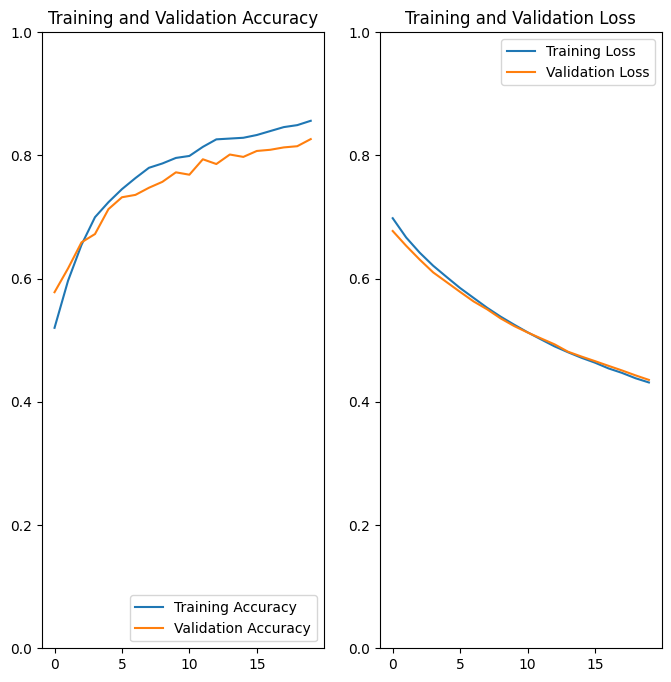

In [24]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylim(0,1.0)
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylim(0,1)
plt.show()

In [25]:
test_loss, test_accuracy = model.evaluate(test_ds)
print(f'Test accuracy: {test_accuracy}, Test loss: {test_loss}')

9/9 [==============================] - 22s 2s/step - loss: 0.4215 - accuracy: 0.8793
Test accuracy: 0.8793103694915771, Test loss: 0.42151743173599243


In [26]:
pd.DataFrame(history.history)

,loss,accuracy,val_loss,val_accuracy
0,0.698166,0.520205,0.677409,0.578035
1,0.666802,0.596536,0.653327,0.616570
2,0.642232,0.654907,0.631002,0.658960
3,0.621024,0.699808,0.610204,0.672447
4,0.602725,0.724182,0.594377,0.712909
5,0.584750,0.745350,0.578488,0.732177
6,0.568753,0.763310,0.563039,0.736031
7,0.552792,0.779987,0.550284,0.747591
8,0.538409,0.787043,0.535556,0.757225
9,0.525400,0.796023,0.523183,0.772640


<Axes: >

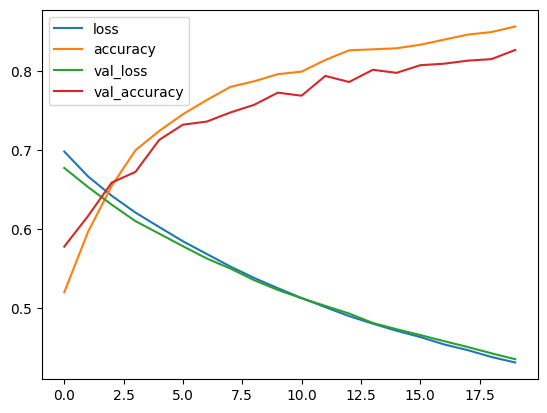

In [27]:
t=pd.DataFrame(history.history)
t.plot()